## Watershaped

In [1]:
import glob
import os
import cv2
import numpy as np

def take_paths(folder_path):
    image_paths = glob.glob(os.path.join(folder_path, '*.jpg'))
    return image_paths

dir_for_imgs = 'tst/Images'
dir_for_masks = 'tst/Masks'

all_imgs_paths = take_paths(dir_for_imgs)
all_masks_paths = take_paths(dir_for_masks)


def resize_images(image_paths, target_size=(256, 256)):
    resized_images = []
    for path in image_paths:
        img = cv2.imread(path)
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)
        
    return np.array(resized_images)
        
def resize_masks(image_paths, target_size=(256, 256)):
    resized_images = []
    for path in image_paths:
        img = cv2.imread(path,0)
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)        
        
    
    return np.array(resized_images)

all_resized_imgs = resize_images(all_imgs_paths)
all_resized_masks = resize_masks(all_masks_paths)

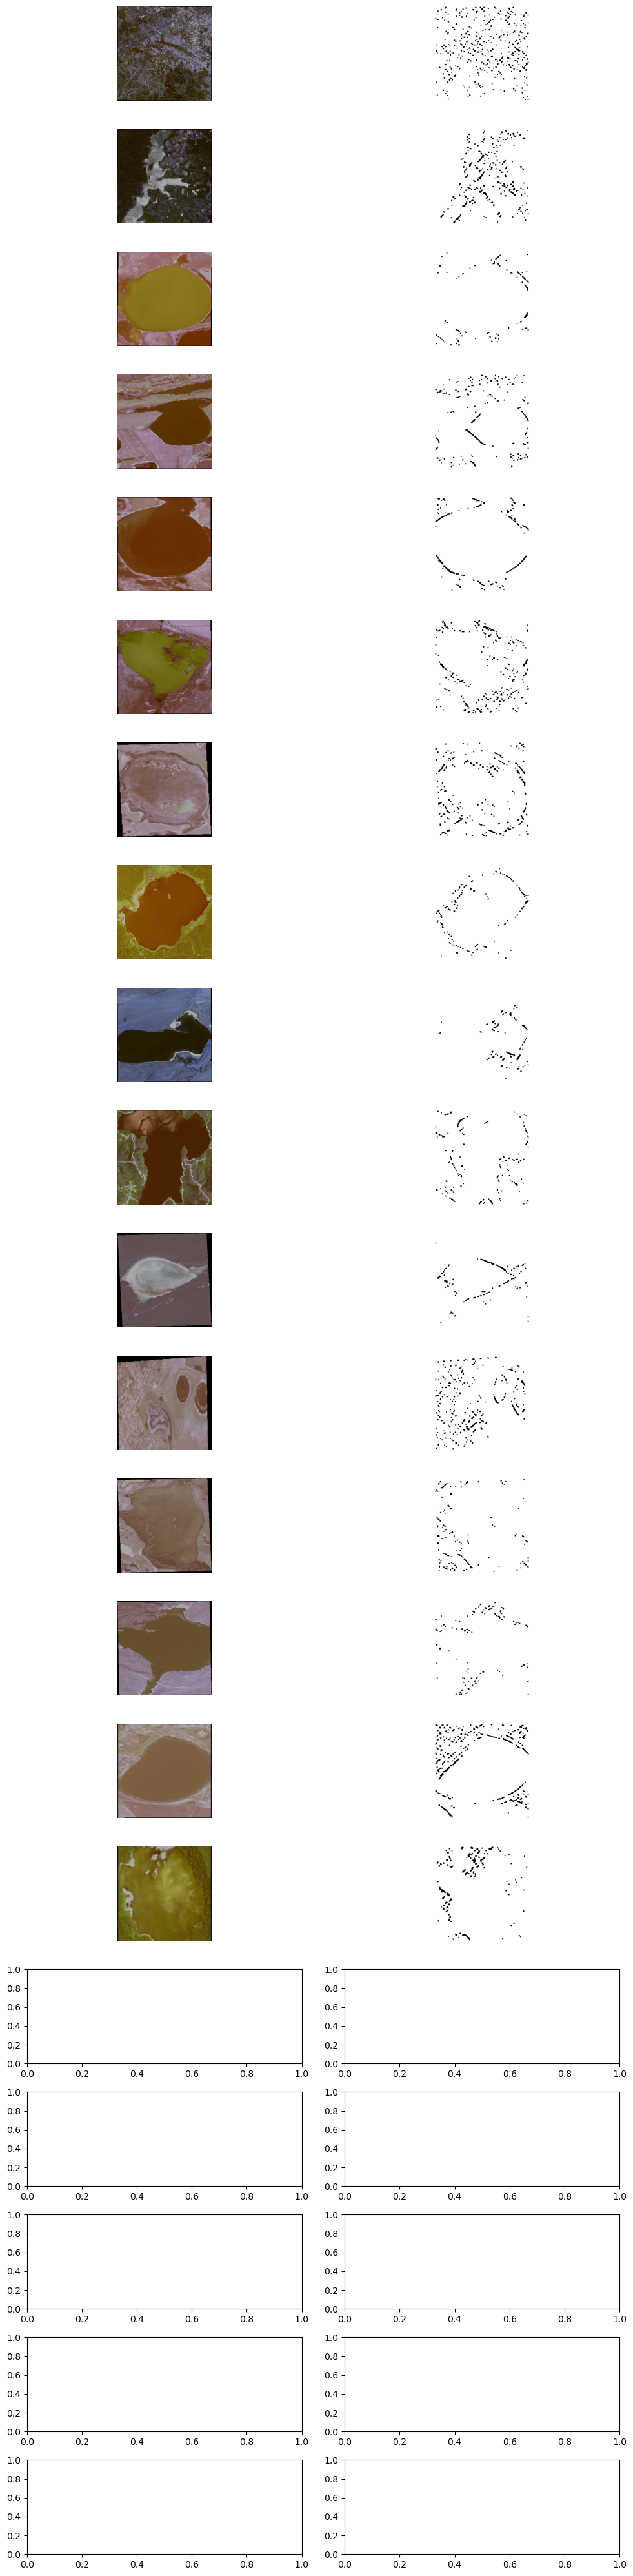

In [14]:
import matplotlib.pyplot as plt


def watershed_segmentation(images):
    segmented_images = []
    for image in images:
        # Преобразование изображения в серый цвет
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Применение фильтра Гаусса для сглаживания
        blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
        
        # Применение оператора Sobel для обнаружения градиентов
        sobel_image = cv2.Sobel(blurred_image, cv2.CV_8U, 1, 1, ksize=5)  # Изменено на CV_8U
        
        # Вычисление маркеров
        ret, thresh = cv2.threshold(sobel_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Очистка маркеров от шумов с помощью морфологической операции
        marker = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
        
        # Применение алгоритма Watershed
        marker = cv2.connectedComponents(marker)[1]  # Получение маркеров Watershed
        
        # Создание маски с цветами для маркеров Watershed
        mask = np.zeros_like(image)
        for m in np.unique(marker):
            if m == 0:
                continue
            mask[marker == m] = np.random.randint(0, 255, 3)
        
        segmented_images.append(mask)
    
    return segmented_images

def convert_to_binary_with_inversion(masked_images):
    binary_masks = []
    for mask in masked_images:
        # Преобразование цветной маски в маску черно-белую
        gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        
        # Инверсия бинарной маски
        inverted_binary = cv2.bitwise_not(binary)
        
        binary_masks.append(inverted_binary)
    return binary_masks


segmented_images = watershed_segmentation(all_resized_imgs)

segmented_images = convert_to_binary_with_inversion(segmented_images)

fig, axes = plt.subplots(21, 2, figsize=(10, 40))

for ax in axes.flat:
    ax.set_aspect('auto')

for i in range(16):
    axes[i, 0].imshow(all_resized_imgs[i])
    axes[i, 0].axis('off')


for i in range(16):
    #pred_masks[i] = pred_masks[i].squeeze()
    axes[i, 1].imshow(segmented_images[i], cmap='gray')
    axes[i, 1].axis('off')

plt.tight_layout()  
plt.show()

In [15]:
def calculate_accuracy(original_masks, predicted_masks):
    accuracies = []
    for original_mask, predicted_mask in zip(original_masks, predicted_masks):
        # Преобразование масок в одноканальные бинарные маски (0 или 1)
        original_binary_mask = (original_mask > 0).astype(int)
        predicted_binary_mask = (predicted_mask > 0).astype(int)
        accuracy = np.mean(original_binary_mask == predicted_binary_mask)
        accuracies.append(accuracy)

    return accuracies

def dice_coefficient(original_mask, predicted_mask):
    # Преобразование масок в бинарные маски (0 или 1)
    original_binary_mask = (np.array(original_mask) > 0).astype(int)
    predicted_binary_mask = (np.array(predicted_mask) > 0).astype(int)

    # Вычисление коэффициента Дайса
    intersection = np.sum(original_binary_mask * predicted_binary_mask)
    union = np.sum(original_binary_mask) + np.sum(predicted_binary_mask)

    dice = (2.0 * intersection) / (union + 1e-8)  # Добавляем 1e-8, чтобы избежать деления на ноль

    return dice

def calculate_iou(original_mask, predicted_mask):
    # Преобразование масок в бинарные маски (0 или 1)
    original_binary_mask = (np.array(original_mask) > 0).astype(int)
    predicted_binary_mask = (np.array(predicted_mask) > 0).astype(int)

    # Вычисление площади пересечения и объединения масок
    intersection = np.logical_and(original_binary_mask, predicted_binary_mask)
    union = np.logical_or(original_binary_mask, predicted_binary_mask)

    iou = np.sum(intersection) / (np.sum(union) + 1e-8)  # Добавляем 1e-8, чтобы избежать деления на ноль

    return iou

acc = calculate_accuracy(all_resized_masks, segmented_images)
dice_score = dice_coefficient(all_resized_masks, segmented_images)
iou = calculate_iou(all_resized_masks, segmented_images)


print('На тестовых данных')
print('Средняя точность: ',np.mean(acc))
print('Макс. точность: ',max(acc))
print('Мин. точность: ',min(acc))
print('Dice coef: ', dice_score)
print('IOU coef: ', iou)

На тестовых данных
Средняя точность:  0.5500669479370117
Макс. точность:  0.795440673828125
Мин. точность:  0.3233795166015625
Dice coef:  0.703995402347885
IOU coef:  0.5432044019159087
